# Предсказание оттока клиентов оператора

1. [Описание проекта](#1)
2. [Загрузка и изучение данных](#2)
3. [Объединение таблиц. Предобработка данных](#3)
4. [Обучение моделей](#4)
    * [Подготовка обучающей и тестовой выборок](#4.1.)
    * [Логистическая регрессия](#4.2.)
    * [Случайный лес](#4.3.) 
    * [СatBoostClassifier](#4.4.)


5. [Итог](#5)
6. [Чек-лист](#6)
7. [Отчет](#6)

## <a id="1"> 1. Описание проекта
Оператору связи «Ниединогоразрыва.ком» необходимо получить модель для прогнозирования оттока клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


#### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

#### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## <a id="2"> 2. Загрузка и изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import inflection
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, make_scorer, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, cv, Pool

Загрузим все доступные нам таблицы и приступим к их изучению.

### NB: 
При изменении ячейки кода загрузки csv-файлов для корректностии выполнения всех ячеек тетрадки необходимо указать для таблицы `contract` параметр `parse_dates=['BeginDate', 'EndDate']`

In [2]:
contract = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\final_provider\\contract.csv', parse_dates=['BeginDate', 'EndDate'])
internet = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\final_provider\\internet.csv')
personal = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\final_provider\\personal.csv')
phone = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\final_provider\\phone.csv')

Изучим загруженные данные. Напишем и вызовем функцию, выводящую на экран первые 5 строк таблицы, информацию о таблице и ее математическое описание.

In [3]:
def review(df):
    '''Выводит первые 5 строк таблицы, информацию о таблице и математическое описание."'''
    print('1. Первые 5 строк таблицы')
    display(df.head())
    print()
    print('2. Информация о таблице')
    print(df.info())
    print()
    print('3. Математическое описание данных')
    print(df.describe())

In [4]:
review(contract)

1. Первые 5 строк таблицы


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



2. Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB
None

3. Математическое описание данных
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000


In [5]:
review(internet)

1. Первые 5 строк таблицы


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



2. Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

3. Математическое описание данных
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     8083-YTZES     Fiber optic             No           No   
freq             1            3096           3498         3088 

In [6]:
review(personal)

1. Первые 5 строк таблицы


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



2. Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

3. Математическое описание данных
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


In [7]:
review(phone)

1. Первые 5 строк таблицы


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



2. Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

3. Математическое описание данных
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     1960-UYCNN            No
freq             1          3390


В наборе данных были две таблицы - `personal1` и `phone1`, которые оказались пустыми. Загрузку этих таблиц мы не производили.

Напишем функцию, приводящую к единообразию заголовки столбцов. Применим ее к нашим таблицам.

In [8]:
def snake_case(df):
    '''Возвращает таблицу с названиями столбцов, преобразованных в snake_case. Обращается к библиотеке inflection.'''
    for column in df.columns.values:
        df = df.rename(columns = {column : inflection.underscore(column)})
    return df

In [9]:
contract, internet, personal, phone = snake_case(contract), snake_case(internet), snake_case(personal), snake_case(phone)

Посчитаем количество значений в столбцах с бинарными признаками.

In [10]:
def df_value_counts(df, j, k):
    '''Возвращает количество уникальных значений таблицы df от столбца k до столбца "количество столбцов минус j"'''
    for i in range(len(df.columns.values)-j):
        print(str(df.columns.values[i+k]))
        display(df[df.columns.values[i+k]].value_counts())

In [11]:
df_value_counts(phone, 1, 1)

multiple_lines


No     3390
Yes    2971
Name: multiple_lines, dtype: int64

In [12]:
phone_index = phone['customer_id']

In [13]:
df_value_counts(personal, 1, 1)

gender


Male      3555
Female    3488
Name: gender, dtype: int64

senior_citizen


0    5901
1    1142
Name: senior_citizen, dtype: int64

partner


No     3641
Yes    3402
Name: partner, dtype: int64

dependents


No     4933
Yes    2110
Name: dependents, dtype: int64

In [14]:
df_value_counts(internet, 1, 1)

internet_service


Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

online_security


No     3498
Yes    2019
Name: online_security, dtype: int64

online_backup


No     3088
Yes    2429
Name: online_backup, dtype: int64

device_protection


No     3095
Yes    2422
Name: device_protection, dtype: int64

tech_support


No     3473
Yes    2044
Name: tech_support, dtype: int64

streaming_tv


No     2810
Yes    2707
Name: streaming_tv, dtype: int64

streaming_movies


No     2785
Yes    2732
Name: streaming_movies, dtype: int64

In [15]:
internet_index = internet['customer_id']

In [16]:
df_value_counts(contract, 5, 3)
print('Количество абонентов, не расторгнувших договор: ',
      contract[contract['end_date'] == 'No']['end_date'].value_counts())
print()
print('Общее количество абонентов: ', contract.shape[0])

type


Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

paperless_billing


Yes    4171
No     2872
Name: paperless_billing, dtype: int64

payment_method


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

Количество абонентов, не расторгнувших договор:  No    5174
Name: end_date, dtype: int64

Общее количество абонентов:  7043


**Описание признаков:**

- customer_id - уникальный идентификатор клиента
- multiple_lines - возможность подключения телефонного аппарата к нескольким линиям одновременно
- gender - пол абонента
- senior_citizen - принадлежность абонента к возрастной категории пожилых людей
- partner - семейное положение (наличие партнера)
- dependents - дети
- internet_service - тип интернет-соединения
- online_security - блокировка небезопасных сайтов
- online_backup - облачное хранилище файлов для резервного копирования данных
- device_protection - антивирус 	
- tech_support - выделенная линия технической поддержки
- streaming_tv - стриминговое телевидение
- streaming_movies - операторский каталог фильмов
- begin_date - дата начала абонентского договора
- end_date - дата расторжения абонентского договора	
- type - тип абонентской платы (помесячно, раз в год, и т.п.)
- paperless_billing - наличие бумажных чеков
- payment_method - способ оплаты
- monthly_charges - ежемесячный платеж
- total_charges - суммарный платеж за весь период обслуживания

## <a id="3"> 3. Объединение таблиц. Предобработка данных

Объединим все наши таблицы в одну общую.

In [17]:
df = pd.merge(contract, personal, how='outer', on='customer_id').merge(
    phone, how='outer', on='customer_id').merge(internet, how='outer', on='customer_id')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     6361 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

В результате объединения таблиц образовались пропуски.  Часть пропусков - отсутствующие записи в таблицах `интернет` и `телефон`. Фактически, это говорит о том, что у указанных пользователей не подключена услуга интернета или телефонии оператора, т.е. можем заполнить пропуски значениями **No**. Остальные признаки, не подразумевающие бинарного ответа, заполним значением **unknown**.

In [19]:
df['multiple_lines'] = df['multiple_lines'].fillna('No')

df['internet_service'] = df['internet_service'].fillna('unknown')

df[internet.columns.values] = df[internet.columns.values].fillna('No')

Проверим датасет на пропуски после заполнения

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

Сравним распределение способов совершения платежей (периодичности) среди ушедших и активных клиентов.

In [21]:
df[df['end_date']=='No']['type'].value_counts()

Month-to-month    2220
Two year          1647
One year          1307
Name: type, dtype: int64

In [22]:
df['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

In [23]:
print('Процент ушедших пользователей с ежемесячными платежами: {:.2%}'.format((3875-2220)/3875))
print('Процент ушедших пользователей с платежами раз в год: {:.2%}'.format((1473-1307)/1473))
print('Процент ушедших пользователей с платежами раз в два года: {:.2%}'.format((1695-1647)/1695))

Процент ушедших пользователей с ежемесячными платежами: 42.71%
Процент ушедших пользователей с платежами раз в год: 11.27%
Процент ушедших пользователей с платежами раз в два года: 2.83%


Видим, что чем больше период оплаты, тем меньше вероятность того, что пользователь откажется от услуг оператора. При оплате за месяц процент ушедших составляет чуть больше 42%, при оплате раз в 2 года всего чуть меньше 3%. Такое положение дел вполне закономерно, человек, оплачивающий услуги на 2 года вперед, скорее всего весьма уверен в принятом решении пользоваться этими услугами. Дополнительный фактор - остаток оплаченного периода. Наименее вероятно, что пользователь откажется от услуг, за которые он уже заплатил (только в крайних случаях).

Также приходим к еще одной проблеме данных: в нашей таблице содержится признак "ежемесячный платеж", тогда как многие пользователи не платят ежемесячно. Попробуем ввести признак "разовый платеж".

In [24]:
df.loc[(df.type == 'Month-to-month'), 'number_of_months'] = 1
df.loc[(df.type == 'One year'), 'number_of_months'] = 12
df.loc[(df.type == 'Two year'), 'number_of_months'] = 24

df['payment_size'] = df['monthly_charges'] * df['number_of_months']

Введем в набор данных целевой признак: пользователь ушел - **1**, пользователь не отказался от услуг оператора - **0**.

In [25]:
df.loc[(df.end_date == 'No'), 'has_left'] = 0
df.loc[(df.end_date != 'No'), 'has_left'] = 1
df['has_left'] = df['has_left'].astype(int)

In [26]:
df.loc[df['customer_id'].isin(internet_index)]['has_left'].value_counts()

0    3761
1    1756
Name: has_left, dtype: int64

Проверим, пользователи какой услуги (интернет или телефония) более склонны к уходу.

In [27]:
df.loc[df['customer_id'].isin(phone_index)]['has_left'].value_counts()

0    4662
1    1699
Name: has_left, dtype: int64

In [28]:
answer = internet.merge(phone, on='customer_id', how='inner')
answer_index = answer['customer_id']
df.loc[df['customer_id'].isin(answer_index)]['has_left'].value_counts()

0    3249
1    1586
Name: has_left, dtype: int64

Видим равномерное распределение отказывающихся от услуг оператора как среди пользователей интернет-услуг, так и среди телефонных абонентов, как для пользователей услугами по-отдельности, так и в совокупности. Мы не можем сказать, что активнее уходят пользователи какой-то конкретной услуги.

Рассчитаем показатель `"время жизни клиента"`. Для этого заполним актуальной датой значения даты окончания действия договора для активных пользователей.

In [29]:
df.loc[(df.end_date == 'No'), 'end_date'] = '2020-02-01 00:00:00'
df['end_date'] = pd.to_datetime(df['end_date'])
df['lifetime'] = df['end_date'] - df['begin_date']
df['lifetime'] = pd.to_numeric(df['lifetime'].dt.days, downcast='integer') / 30

Для дополнитеольного изучения информации о пользователях добавим показатели месяца и года.

*(В датасет для обучения модели эти данные включены не будут)*

In [30]:
df.loc[(df.has_left == 1), 'end_month'] = df['end_date'].apply(lambda x: x.month)
df.loc[(df.has_left == 1), 'end_year'] = df['end_date'].apply(lambda x: x.year)

df['begin_month'] = df['begin_date'].apply(lambda x: x.month)
df['begin_year'] = df['begin_date'].apply(lambda x: x.year)

Месяцы и года, в которые клиенты уходили от оператора.

In [31]:
df['end_month'].value_counts()

11.0    485
12.0    466
1.0     460
10.0    458
Name: end_month, dtype: int64

In [32]:
df['end_year'].value_counts()

2019.0    1409
2020.0     460
Name: end_year, dtype: int64

Интересно, что более чем за 6 лет работы оператор не терял клиентов до последнего полугодия.

В какие месяцы новые клиенты приходят активнее:

In [33]:
df['begin_month'].value_counts()

2     804
1     623
9     623
11    621
12    604
10    601
3     590
8     532
6     522
7     518
4     511
5     494
Name: begin_month, dtype: int64

По месяцам новые пользователи распределились равномерно. Данные с октября 2013 года по февраль 2020, закономерно в эти месяцы наибольшее количество новоприбывших пользователей.

В какие года сколько новых пользователей пришло к оператору.

In [34]:
df['begin_year'].value_counts()

2019    1957
2014    1344
2018    1030
2015     852
2017     845
2016     763
2020     244
2013       8
Name: begin_year, dtype: int64

Посмотрим, сколько месяцев проходит до того, как пользователь принимает решение уйти (и в каком количестве пользователи уходят через какой промежуток времени).

In [35]:
df.loc[(df.end_date != 'No'), 'lifetime'].apply(lambda x: round(x)).value_counts().sort_values(ascending=False).head(20)

1     613
73    362
2     238
3     200
4     176
72    170
5     133
7     131
36    127
8     123
9     119
71    119
32    118
12    117
10    116
6     110
13    109
69    100
15     99
11     99
Name: lifetime, dtype: int64

In [80]:
print('Процент пользователей, ушедших в первые полгода после подключения {:.2%}'.format(
    (613+238+200+176+133+110)/df['has_left'].sum()))

Процент пользователей, ушедших в первые полгода после подключения 78.69%


В первые полгода после подключения уходит почти 80% пользователей. Более того, больше всего пользователей уходят после первого месяца с подключения. Также уходит достаточно много самых старых клиентов.

Разметим пользователей на "новых или старых" и "обычных".

In [37]:
df.loc[(df.lifetime <= 2), 'ordinal'] = 0
df.loc[(df.lifetime >= 70), 'ordinal'] = 0
df['ordinal'] = df['ordinal'].fillna(1)
df['ordinal'] = df['ordinal'].astype(int)

In [38]:
df.ordinal.value_counts()

1    5677
0    1366
Name: ordinal, dtype: int64

Закодируем категориальные признаки.

In [39]:
df[internet.columns.values] = df[internet.columns.values].replace(['Yes', 'No'], [1, 0])
df[phone.columns.values] = df[phone.columns.values].replace(['Yes', 'No'], [1, 0])

In [40]:
data = df[['type', 'paperless_billing', 'payment_method', 'gender',
           'senior_citizen', 'partner', 'dependents', 'internet_service']]

encoder = OrdinalEncoder()

df_ordinal = pd.DataFrame(encoder.fit_transform(data),
                            columns=data.columns)

df[['type', 'paperless_billing', 'payment_method', 'gender',
    'senior_citizen', 'partner', 'dependents', 'internet_service']] = df_ordinal.astype(int)

In [41]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,streaming_movies,number_of_months,payment_size,has_left,lifetime,end_month,end_year,begin_month,begin_year,ordinal
0,7590-VHVEG,2020-01-01,2020-02-01,0,1,2,29.85,29.85,0,0,...,0,1.0,29.85,0,1.033333,NaN,NaN,1,2020,0
1,5575-GNVDE,2017-04-01,2020-02-01,1,0,3,56.95,1889.5,1,0,...,0,12.0,683.40,0,34.533333,NaN,NaN,4,2017,1
2,3668-QPYBK,2019-10-01,2019-12-01,0,1,3,53.85,108.15,1,0,...,0,1.0,53.85,1,2.033333,12.0,2019.0,10,2019,1
3,7795-CFOCW,2016-05-01,2020-02-01,1,0,0,42.30,1840.75,1,0,...,0,12.0,507.60,0,45.700000,NaN,NaN,5,2016,1
4,9237-HQITU,2019-09-01,2019-11-01,0,1,2,70.70,151.65,0,0,...,0,1.0,70.70,1,2.033333,11.0,2019.0,9,2019,1


Создадим признак "количество подключенных опций".

In [42]:
df['number_of_options'] = (df['online_security'] + df['tech_support'] +
                           df['online_backup'] + df['device_protection'] + 
                           df['streaming_tv'] + df['streaming_movies'])

Приведем признак `'total_charges'` к числовому типу.

In [43]:
df['total_charges'] = pd.to_numeric(df.total_charges, errors='coerce')

Изучим строки с пропусками.

In [44]:
df[df['total_charges'].isna() == True]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,number_of_months,payment_size,has_left,lifetime,end_month,end_year,begin_month,begin_year,ordinal,number_of_options
488,4472-LVYGI,2020-02-01,2020-02-01,2,1,0,52.55,NaN,0,0,...,24.0,1261.2,0,0.0,NaN,NaN,2,2020,0,4
753,3115-CZMZD,2020-02-01,2020-02-01,2,0,3,20.25,NaN,1,0,...,24.0,486.0,0,0.0,NaN,NaN,2,2020,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,2,0,3,80.85,NaN,0,0,...,24.0,1940.4,0,0.0,NaN,NaN,2,2020,0,5
1082,4367-NUYAO,2020-02-01,2020-02-01,2,0,3,25.75,NaN,1,0,...,24.0,618.0,0,0.0,NaN,NaN,2,2020,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,2,0,1,56.05,NaN,0,0,...,24.0,1345.2,0,0.0,NaN,NaN,2,2020,0,5
3331,7644-OMVMY,2020-02-01,2020-02-01,2,0,3,19.85,NaN,1,0,...,24.0,476.4,0,0.0,NaN,NaN,2,2020,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,2,0,3,25.35,NaN,1,0,...,24.0,608.4,0,0.0,NaN,NaN,2,2020,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,2,0,3,20.00,NaN,0,0,...,24.0,480.0,0,0.0,NaN,NaN,2,2020,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,1,1,3,19.70,NaN,1,0,...,12.0,236.4,0,0.0,NaN,NaN,2,2020,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,2,0,3,73.35,NaN,0,0,...,24.0,1760.4,0,0.0,NaN,NaN,2,2020,0,4


Для новых клиентов суммарный платеж должен быть равен единичному месячному платежу либо 0 при постоплате. Остановимся на первом варианте (даже если фактически платеж еще не был совершен, счет на оплату уже сформирован).

In [45]:
df.loc[(df.total_charges.isna() == True, 'total_charges')] = df['monthly_charges']

Выполним проверку взаимосвязи между бинарными признаками датасета и целевым признаком методом *хи-квадрат.*

In [46]:
# передадим названия столбцов бинарных признаков в список
binary = ['type', 'paperless_billing', 'payment_method',  'gender', 
          'partner', 'dependents', 'multiple_lines', 'internet_service',
          'online_security', 'online_backup', 'device_protection', 'tech_support',
          'streaming_tv', 'streaming_movies', 'ordinal']

In [47]:
chi_square = chi2(df[binary], df['has_left'])

In [48]:
chi_df = pd.DataFrame(chi_square)
chi_df.index = ['statistic', 'p-value']
chi_df.columns = binary

In [49]:
chi_df = chi_df.T.sort_values(by='statistic', ascending=False)
chi_df

,statistic,p-value
type,1115.780167,1.227941e-244
online_security,147.295858,6.761696e-34
tech_support,135.559783,2.490549e-31
dependents,133.036443,8.876729e-31
paperless_billing,105.680863,8.661987e-25
partner,82.412083,1.104764e-19
payment_method,58.492250,2.040933e-14
online_backup,31.217694,2.306541e-08
device_protection,20.226662,6.878750e-06
streaming_tv,17.334235,3.134881e-05


Тест хи-квадрат возвращает p-значение гипотезы о том, что две бинарные переменные независимы. Т.е. чем меньше значение p-value, тем сильнее связь между переменными.

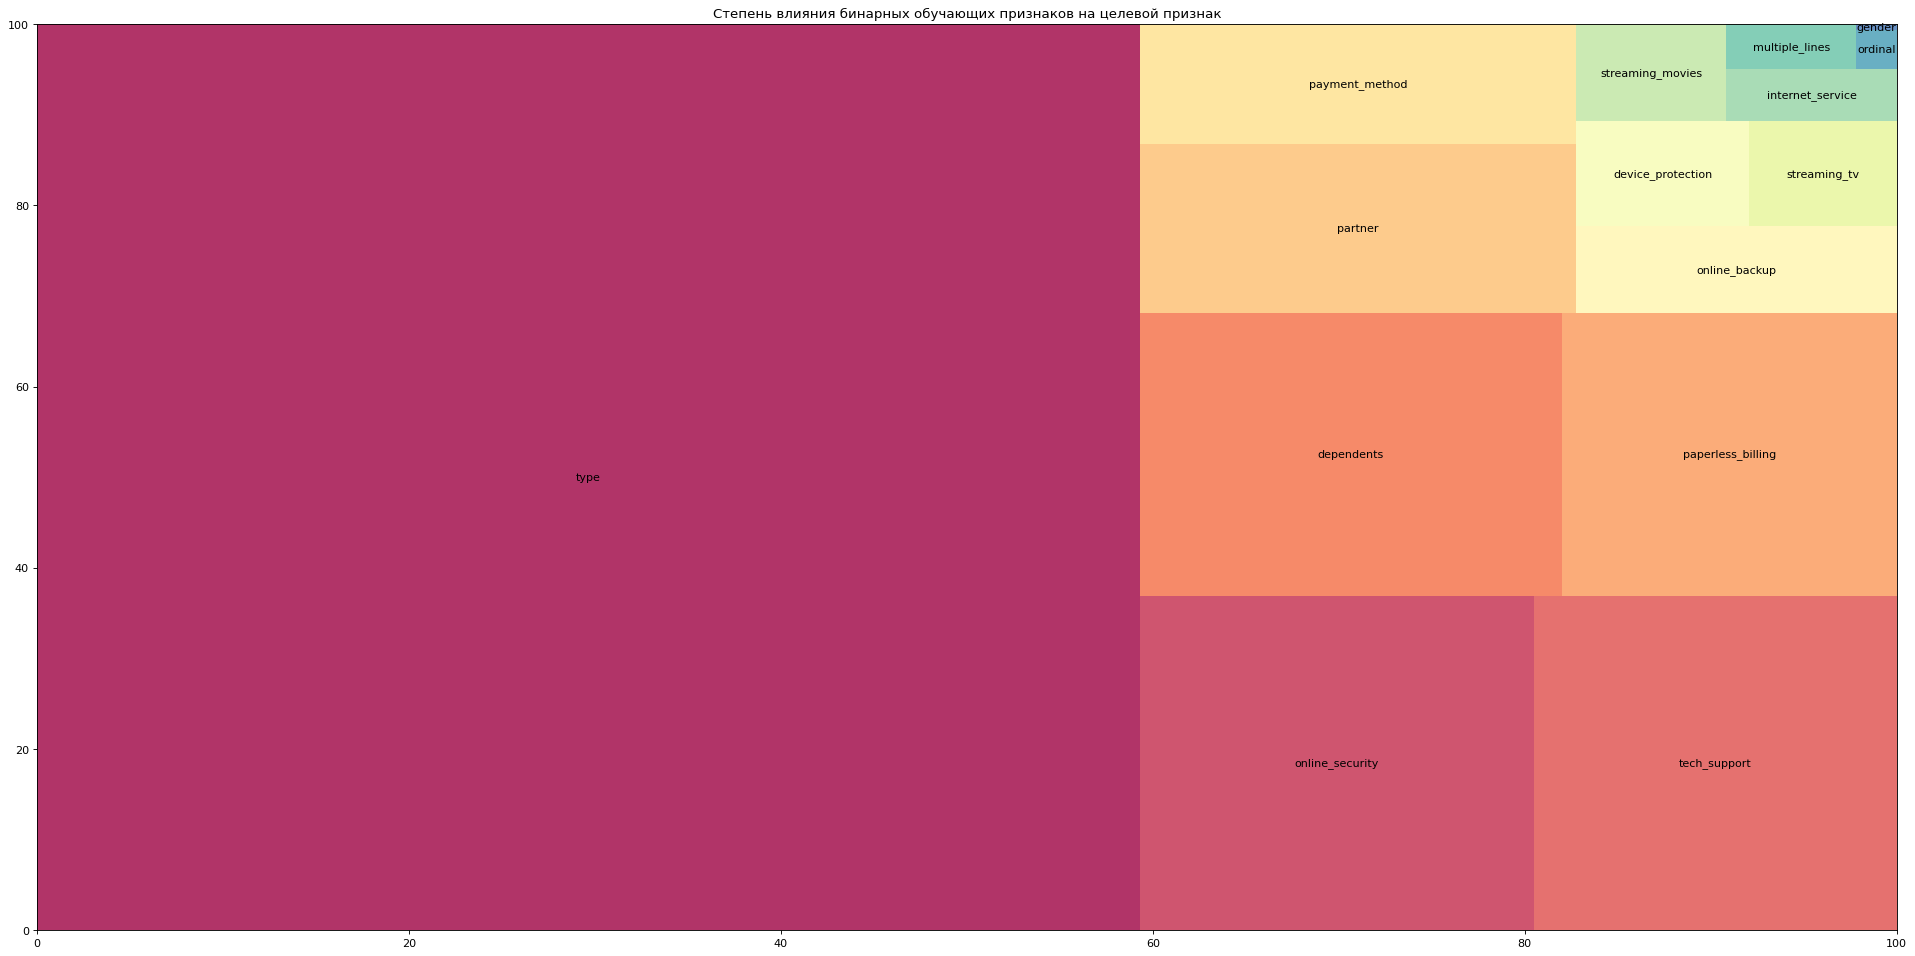

In [50]:
plt.figure(figsize=(30,15), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(chi_df.index))) for i in range(len(chi_df.index))]
squarify.plot(chi_df['statistic'], alpha=.8, label=chi_df.index, color=colors)
plt.title('Степень влияния бинарных обучающих признаков на целевой признак')
plt.show()

Построим диаграммы размаха для количественных признаков.

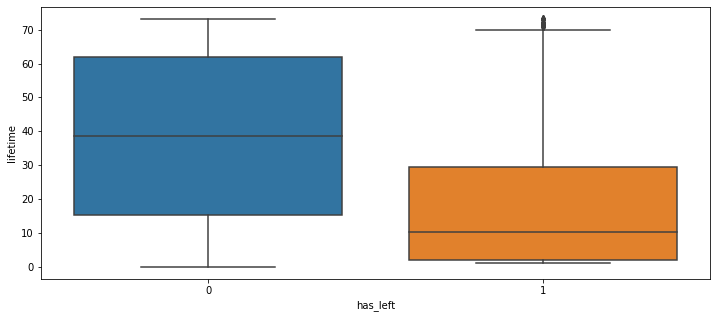

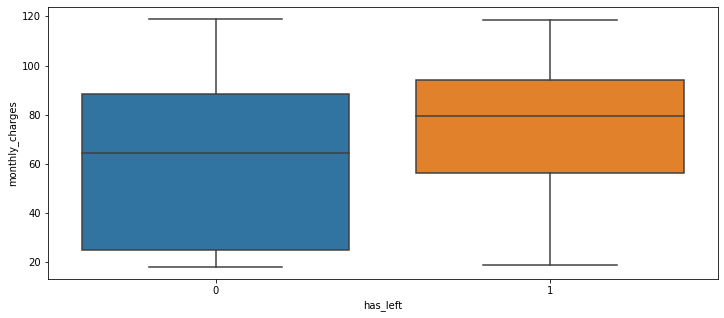

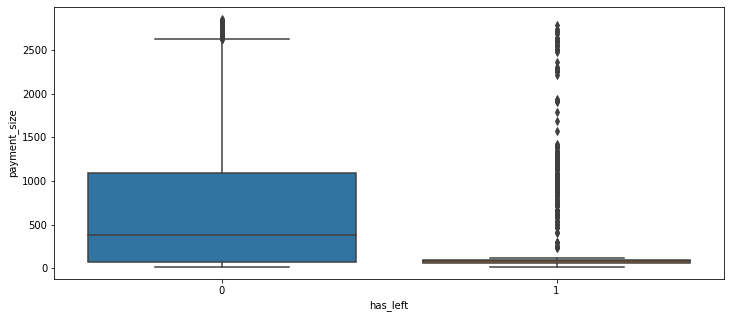

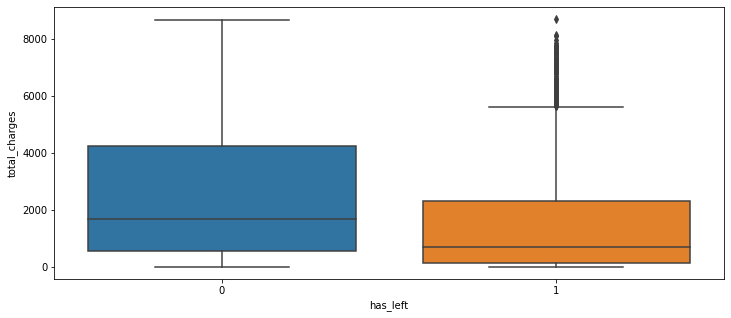

In [51]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['has_left'], y=df['lifetime'])
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x=df['has_left'], y=df['monthly_charges'])
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x=df['has_left'], y=df['payment_size'])
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x=df['has_left'], y=df['total_charges'])
plt.show()

Как мы видим, признак `"ежемесячные платежи"` не содержит выбросов. По `"суммарным платежам"` имеюся выбросы около значения 6000 у.е. и выше. Искусственно сгенерированный признак `"размер единовременного платежа"` для ушедших клиентов в принципе состоит из выбросов (откажемся от его использования при обучении модели). Для признака `"время жизни"` наблюдаем незначительное количество выбросов. Учитывая степень значимости показателя `"время жизни"`, они могут оказывать ощутимое влияние на качество предсказаний модели.

Посмотрим на признаки с пропусками в данных.

In [52]:
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines          0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
number_of_months        0
payment_size            0
has_left                0
lifetime                0
end_month            5174
end_year             5174
begin_month             0
begin_year              0
ordinal                 0
number_of_options       0
dtype: int64

Построим и сравним графики распределения общих платежей, ежемесячных платежей и величины одного платежа для активных клиентов и тех клиентов, которые отказались от услуг оператора.

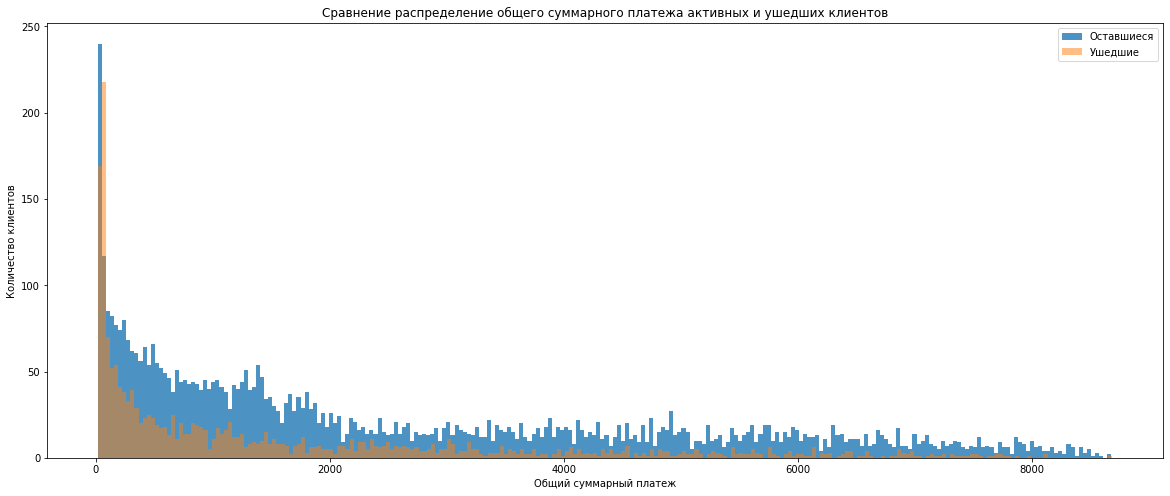

In [53]:
plt.figure(figsize=(20, 8))
plt.hist(df[df['has_left']==0]['total_charges'], bins=250, alpha=.8, label='Оставшиеся')
plt.hist(df[df['has_left']==1]['total_charges'], bins=250, alpha=.5, label='Ушедшие')
plt.xlabel("Общий суммарный платеж")
plt.ylabel("Количество клиентов")
plt.title("Сравнение распределение общего суммарного платежа активных и ушедших клиентов")
plt.legend()
plt.show()


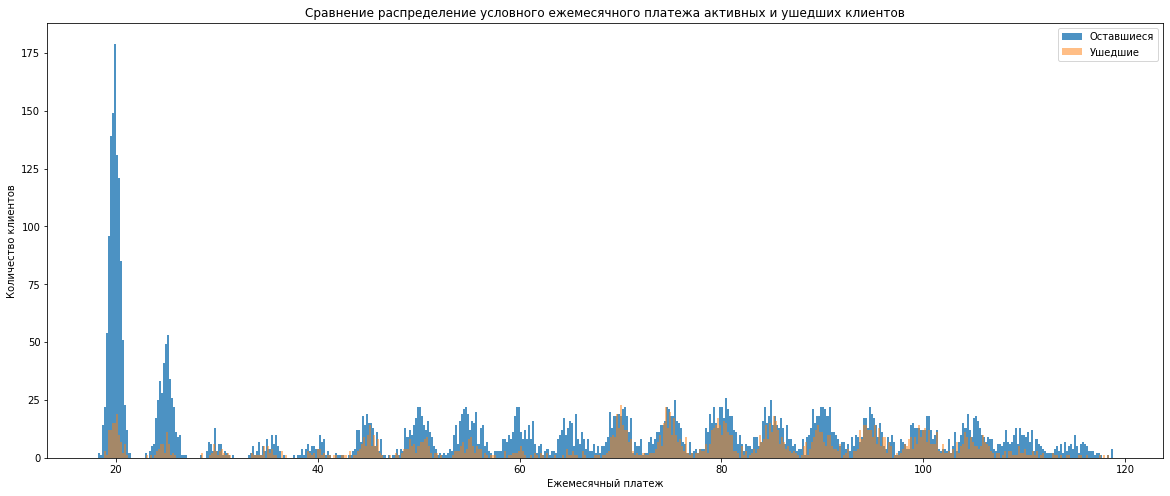

In [54]:
plt.figure(figsize=(20, 8))
plt.hist(df[df['has_left']==0]['monthly_charges'], bins=500, alpha=.8, label='Оставшиеся')
plt.hist(df[df['has_left']==1]['monthly_charges'], bins=500, alpha=.5, label='Ушедшие')
plt.xlabel("Ежемесячный платеж")
plt.ylabel("Количество клиентов")
plt.title("Сравнение распределение условного ежемесячного платежа активных и ушедших клиентов")
plt.legend()
plt.show()


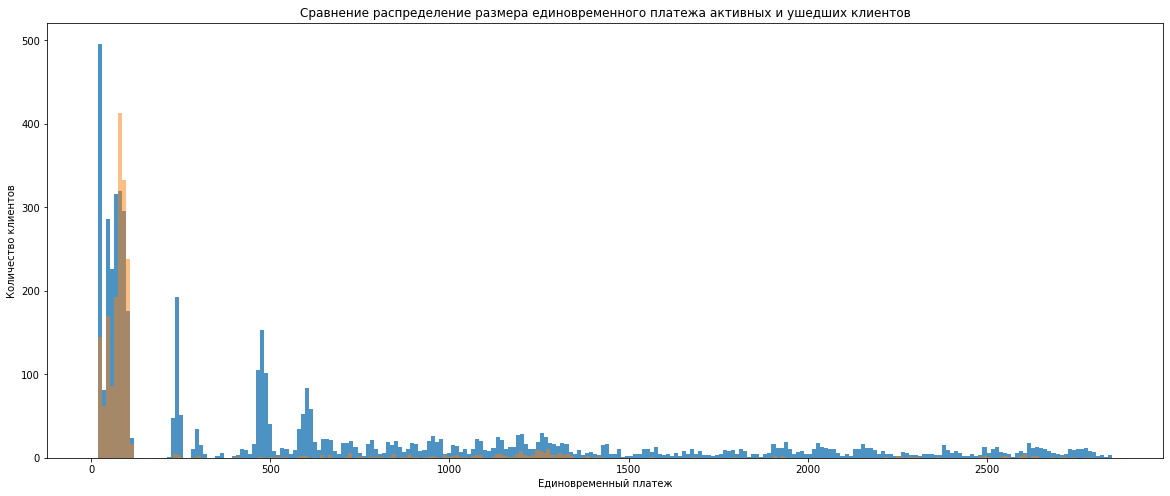

In [55]:
plt.figure(figsize=(20, 8))
plt.hist(df[df['has_left']==0]['payment_size'], bins=250, alpha=.8, label='Оставшиеся')
plt.hist(df[df['has_left']==1]['payment_size'], bins=250, alpha=.5, label='Ушедшие')
plt.xlabel("Единовременный платеж")
plt.ylabel("Количество клиентов")
plt.title("Сравнение распределение размера единовременного платежа активных и ушедших клиентов")
plt.show()

Распределения схожи, при этом видна степень влияния стоимости услуг на решение об уходе.

In [56]:
# отключим ограничение на отображение столбцов датафрейма
pd.set_option('display.max_columns', None)
review(df)

1. Первые 5 строк таблицы


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,number_of_months,payment_size,has_left,lifetime,end_month,end_year,begin_month,begin_year,ordinal,number_of_options
0,7590-VHVEG,2020-01-01,2020-02-01,0,1,2,29.85,29.85,0,0,1,0,0,0,0,1,0,0,0,0,1.0,29.85,0,1.033333,NaN,NaN,1,2020,0,1
1,5575-GNVDE,2017-04-01,2020-02-01,1,0,3,56.95,1889.50,1,0,0,0,0,0,1,0,1,0,0,0,12.0,683.40,0,34.533333,NaN,NaN,4,2017,1,2
2,3668-QPYBK,2019-10-01,2019-12-01,0,1,3,53.85,108.15,1,0,0,0,0,0,1,1,0,0,0,0,1.0,53.85,1,2.033333,12.0,2019.0,10,2019,1,2
3,7795-CFOCW,2016-05-01,2020-02-01,1,0,0,42.30,1840.75,1,0,0,0,0,0,1,0,1,1,0,0,12.0,507.60,0,45.700000,NaN,NaN,5,2016,1,3
4,9237-HQITU,2019-09-01,2019-11-01,0,1,2,70.70,151.65,0,0,0,0,0,1,0,0,0,0,0,0,1.0,70.70,1,2.033333,11.0,2019.0,9,2019,1,0



2. Информация о таблице
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   int32         
 4   paperless_billing  7043 non-null   int32         
 5   payment_method     7043 non-null   int32         
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   int32         
 9   senior_citizen     7043 non-null   int32         
 10  partner            7043 non-null   int32         
 11  dependents         7043 non-null   int32         
 12  multiple_lines     7043 non-null   int64         
 13  internet_service   7043 non-null   int

Клиенты с самым большим разовым платежом.

In [57]:
df.sort_values(by='payment_size', ascending=False).head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,number_of_months,payment_size,has_left,lifetime,end_month,end_year,begin_month,begin_year,ordinal,number_of_options
4586,7569-NMZYQ,2014-02-01,2020-02-01,2,1,0,118.75,8672.45,0,0,1,1,1,1,1,1,1,1,1,1,24.0,2850.0,0,73.033333,NaN,NaN,2,2014,0,6
2115,8984-HPEMB,2014-03-01,2020-02-01,2,1,2,118.65,8477.60,0,0,0,0,1,1,1,1,1,1,1,1,24.0,2847.6,0,72.100000,NaN,NaN,3,2014,0,6
3894,5989-AXPUC,2014-06-01,2020-02-01,2,0,3,118.60,7990.05,0,0,1,0,1,1,1,1,1,1,1,1,24.0,2846.4,0,69.033333,NaN,NaN,6,2014,1,6
6118,9924-JPRMC,2014-02-01,2020-02-01,2,1,2,118.20,8547.15,1,0,0,0,1,1,1,1,1,1,1,1,24.0,2836.8,0,73.033333,NaN,NaN,2,2014,0,6
3205,3810-DVDQQ,2014-02-01,2020-02-01,2,1,0,117.60,8308.90,0,0,1,1,1,1,1,1,1,1,1,1,24.0,2822.4,0,73.033333,NaN,NaN,2,2014,0,6


Проверим, как уходят клиенты с максимальным суммарным платежом.

In [58]:
df.sort_values(by='total_charges', ascending=False).head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,number_of_months,payment_size,has_left,lifetime,end_month,end_year,begin_month,begin_year,ordinal,number_of_options
4610,2889-FPWRM,2013-10-01,2019-10-01,1,1,0,117.80,8684.80,1,0,1,0,1,1,1,1,1,1,1,1,12.0,1413.6,1,73.033333,10.0,2019.0,10,2013,0,6
4586,7569-NMZYQ,2014-02-01,2020-02-01,2,1,0,118.75,8672.45,0,0,1,1,1,1,1,1,1,1,1,1,24.0,2850.0,0,73.033333,NaN,NaN,2,2014,0,6
6768,9739-JLPQJ,2014-02-01,2020-02-01,2,0,1,117.50,8670.10,0,0,1,1,1,1,1,1,1,1,1,1,24.0,2820.0,0,73.033333,NaN,NaN,2,2014,0,6
5347,9788-HNGUT,2014-02-01,2020-02-01,2,1,1,116.95,8594.40,1,0,1,0,1,1,1,1,1,1,1,1,24.0,2806.8,0,73.033333,NaN,NaN,2,2014,0,6
2187,8879-XUAHX,2014-03-01,2020-02-01,2,1,2,116.25,8564.75,1,0,1,0,1,1,1,1,1,1,1,1,24.0,2790.0,0,72.100000,NaN,NaN,3,2014,0,6


Мы вывели на экран первые 5 строк таблицы, но при изучении первых 50 клиентов оказалось, что 49 из них ушли, и только один остался. При этом остался клиент с максимальным общим платежом. Очевидно, удаление одного клиента из датасета не исказит реальных данных, при этом предсказания модели могут улучшиться.

In [59]:
df = df.drop(4610)

Посмотрим, как выглядит картина по приходу новых клиентов по годам и по уходу существующих клиентов.

In [60]:
gone = df.groupby(['end_year', 'end_month']).count()['has_left'].reset_index()
gone

,end_year,end_month,has_left
0,2019.0,10.0,457
1,2019.0,11.0,485
2,2019.0,12.0,466
3,2020.0,1.0,460


In [61]:
come = df.groupby(['begin_year']).count()['customer_id'].reset_index()
come

,begin_year,customer_id
0,2013,7
1,2014,1344
2,2015,852
3,2016,763
4,2017,845
5,2018,1030
6,2019,1957
7,2020,244


Клиенты уходили от оператора на протяжении 4-х месяцев подряд с октября 2019 г. по январь 2020 г. в количестве от 458 до 485 человек в месяц. Поскольку данные актуальны на февраль 2020 г., не исключено, что тенденция сохранится.

С другой стороны, интересно то, что до октября 2019 года нет ни одной записи об ушедшем клиенте. Ситуация может косвенно указывать на нового серьезного конкурента для когда-то монополиста.

Всего 8 человек стали абонентами в 2013 году. Изучим их подробнее.

In [62]:
df[df['begin_year']==2013]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,number_of_months,payment_size,has_left,lifetime,end_month,end_year,begin_month,begin_year,ordinal,number_of_options
975,2834-JRTUA,2013-11-01,2019-10-01,2,1,2,108.05,7532.15,1,0,0,0,1,1,1,0,1,1,1,1,24.0,2593.2,1,72.000000,10.0,2019.0,11,2013,0,5
3040,7317-GGVPB,2013-11-01,2019-10-01,2,1,1,108.60,7690.90,1,0,1,0,1,1,0,1,1,1,1,1,24.0,2606.4,1,72.000000,10.0,2019.0,11,2013,0,5
3439,0917-EZOLA,2013-10-01,2019-10-01,2,1,0,104.15,7689.95,1,1,1,0,1,1,0,1,1,0,1,1,24.0,2499.6,1,73.033333,10.0,2019.0,10,2013,0,4
4513,8580-QVLOC,2013-10-01,2019-10-01,2,0,1,92.45,6440.25,0,1,1,1,1,0,1,1,1,1,1,1,24.0,2218.8,1,73.033333,10.0,2019.0,10,2013,0,6
5441,3512-IZIKN,2013-12-01,2019-10-01,2,0,1,65.30,4759.75,0,0,1,0,1,0,1,0,1,1,0,0,24.0,1567.2,1,71.000000,10.0,2019.0,12,2013,0,3
6038,1555-DJEQW,2013-12-01,2019-10-01,2,1,0,114.20,7723.90,0,0,1,1,1,1,1,1,1,1,1,1,24.0,2740.8,1,71.000000,10.0,2019.0,12,2013,0,6
6290,2530-ENDWQ,2013-12-01,2019-11-01,2,1,0,93.70,6585.35,0,0,1,0,1,1,0,0,0,0,1,1,24.0,2248.8,1,72.033333,11.0,2019.0,12,2013,0,2


Все клиенты, пришедшие в 2013-м году, ушли в 2019-м. 7 из нах платили раз в 2 года, один - раз в год. Их объединяет большой период оплаты, к концу которого и было принято решение отказаться от услуг оператора.

Проверка финального датасета на дублирующиеся объекты:

In [63]:
df.duplicated().sum()

0

Дубликатов нет.

## <a id="4"> 4. Обучение моделей

### <a id="4.1."> 4.1. Подготовка обучающей и тестовой выборок

Подготовим набор фичей и таргет на основе набора данных датафрейма **df**.

На основании **feature_importance** модели, обученной на всех признаках, исключим из обучения незначительные признаки.
<img src="https://i.ibb.co/smqFLqK/2021-07-05-20-01-32.png">

In [64]:
features = df.drop(['customer_id', 'begin_date', 'end_date', 'has_left', 'end_month', 'partner', 'gender',
                    'end_year', 'begin_month', 'begin_year', 'number_of_months', 'device_protection', 'ordinal',
                   'online_security', 'online_backup', 'multiple_lines', 'payment_size', 'paperless_billing',
                   'tech_support', 'dependents', 'streaming_tv', 'streaming_movies', 'senior_citizen'], axis=1) 
             

target = df['has_left']

# передадим в переменную rs значение random_state для будущих моделей
rs = 605

Разделим набор фичей и таргет на обучающую и тестовую выборки, выведем на экран размер полученных выборок.

In [65]:
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=.2, random_state=rs , stratify=target)

In [66]:
print('feat_train:', features_train.shape, 'target_train:', target_train.shape,
      'feat_test:', features_test.shape, 'target_test:', target_test.shape)

feat_train: (5633, 7) target_train: (5633,) feat_test: (1409, 7) target_test: (1409,)


### <a id="4.2."> 4.2. Логистическая регрессия

Получим предсказания и метрики их точности для логистической регрессии.

In [67]:
linear_model = LogisticRegression(solver='lbfgs', max_iter=10000)
linear_model.fit(features_train, target_train)
predictions = linear_model.predict(features_test)
scorea = accuracy_score(target_test, predictions)
scorer = roc_auc_score(target_test, predictions)
print('Accuracy score: {:.3}'.format(scorea))
print('AUC-ROC score: {:.3}'.format(scorer))

Accuracy score: 0.788
AUC-ROC score: 0.696


### <a id="4.3."> 4.3. Случайный лес

In [68]:
# создадим скорер для оценки модели на кросс-валидации
auc_roc = make_scorer(roc_auc_score,  greater_is_better=True)

Результат модели случайного леса:

`Наиболее оптимальное значение параметра n_estimators: 80
Наиболее оптимальное значение параметра max_depth: 12
Список значение AUC-ROC по блокам кросс-валидации: [0.74547574 0.75620894 0.73061027 0.71079879 0.71948674 0.73573447
 0.75489224 0.69138796 0.71079879 0.69593227]
Итоговое значение AUC-ROC: 0.725132619555308
Wall time: 23min 18s`

In [69]:
forest_model = RandomForestClassifier(n_estimators=80, max_depth=12, random_state=rs)
forest_model.fit(features_train, target_train)
forest_predict = forest_model.predict(features_test)
accuracy = accuracy_score(target_test, forest_predict)
aucroc = roc_auc_score(target_test, forest_predict)

print('Accuracy score: {:.3}'.format(accuracy))
print('AUC-ROC score: {:.3}'.format(aucroc))

Accuracy score: 0.823
AUC-ROC score: 0.731


### <a id="4.4."> 4.4. CatBoostClassifier

In [70]:
cat_model = CatBoostClassifier(iterations=5000, depth=3, l2_leaf_reg = 3,
                               learning_rate = 0.04, random_seed=rs, loss_function='CrossEntropy',
                               eval_metric='AUC')

In [71]:
cat_model.fit(features_train, target_train, eval_set=(features_test, target_test),
              logging_level='Silent', plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

График обучения модели CatBoostClassifier
<img src = 'https://i.ibb.co/4tzmGRn/2021-07-06-22-24-38.png'>

In [72]:
print('Итоговое количество деревьев:', cat_model.tree_count_)

Итоговое количество деревьев: 4133


In [73]:
cat_predict = cat_model.predict(features_test)
cat_predict_proba = (cat_model.predict_proba(features_test)[:,1] > 0.306).astype(bool)

In [74]:
result_roc_05 = roc_auc_score(target_test, cat_predict)
result_acc_05 = accuracy_score(target_test, cat_predict)
result_recall_05 = recall_score(target_test, cat_predict)
result_precision_05 = precision_score(target_test, cat_predict)

result_roc_0306 = roc_auc_score(target_test, cat_predict_proba)
result_acc_0306 = accuracy_score(target_test, cat_predict_proba)
result_recall_0306 = recall_score(target_test, cat_predict_proba)
result_precision_0306 = precision_score(target_test, cat_predict_proba)

catboost_result = pd.DataFrame({'Proba' : ['0.5', '0.306'],
                                'ROC-AUC' : [result_roc_05, result_roc_0306],
                                'Accuracy' : [result_acc_05, result_acc_0306],
                                'Precision' : [result_precision_05, result_precision_0306],
                                'Recall' : [result_recall_05, result_recall_0306]})

catboost_result

,Proba,ROC-AUC,Accuracy,Precision,Recall
0,0.5,0.824001,0.890703,0.87931,0.681818
1,0.306,0.850570,0.875798,0.75063,0.796791


При использовании не предсказаний классов, а предсказаний вероятности класса, получаем увеличение метрики **AUC-ROC c 0.824 до 0.851**. При этом значение *accuracy* остается без изменений, а *precision и recall* меняются местами: предсказания становятся менее точными, но учитывают большее холичество *true-positive* объектов.

Построим `ROC-кривую` для модели **CatBoost**.

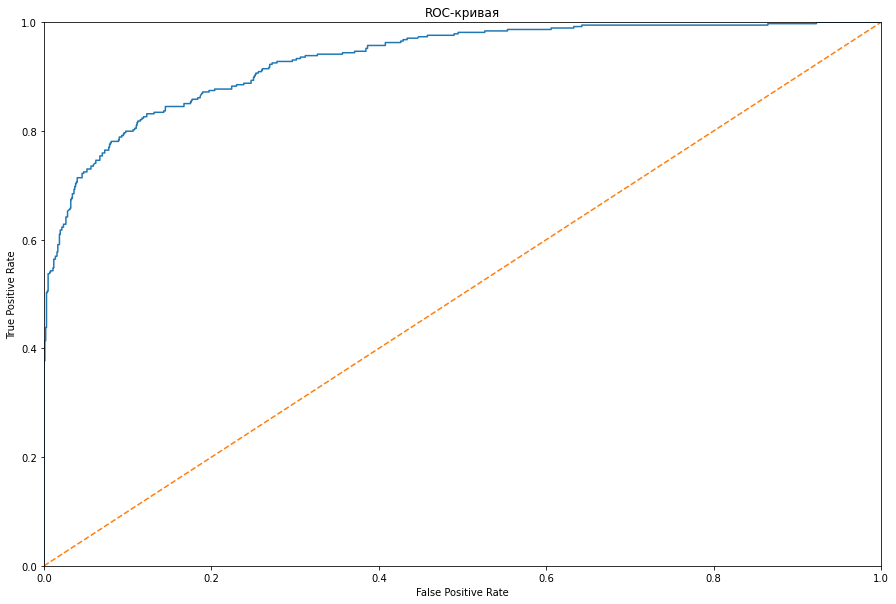

In [75]:
probabilities_test = cat_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(plt.figure(figsize=(15, 10)))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Посмотрим на важность признаков при обучении модели **CatBoost**.

In [76]:
importances = cat_model.feature_importances_


# train_features is the dataframe of training features
feature_list = list(features_train.columns)

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

# Show the most important
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results

,feature,importance
0,lifetime,62.678794
1,monthly_charges,13.006700
2,total_charges,9.384518
3,type,6.953664
4,internet_service,3.872751
5,payment_method,2.294439
6,number_of_options,1.809134


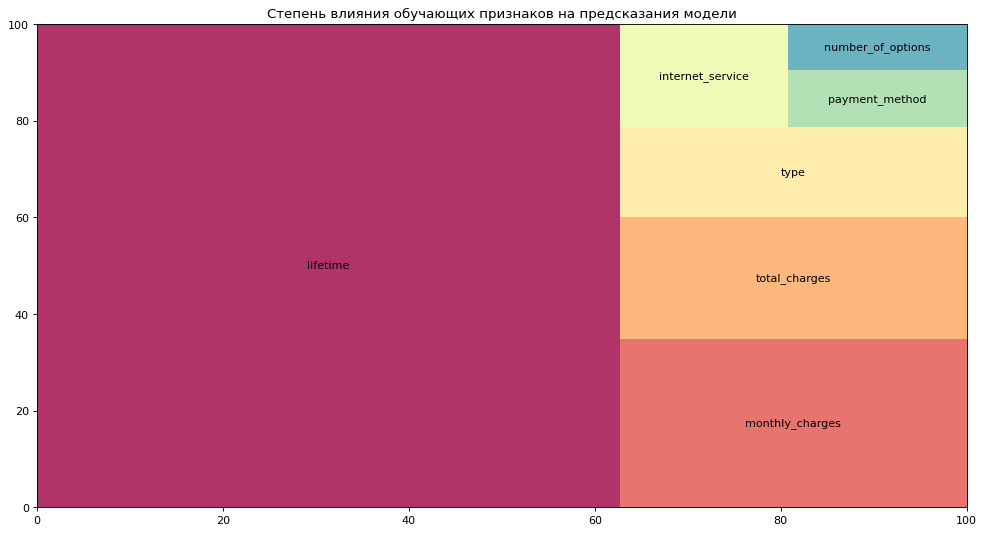

In [77]:
plt.figure(figsize=(15,8), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(feature_results.index))) for i in range(len(feature_results.index))]
squarify.plot(feature_results['importance'], alpha=.8, label=feature_results['feature'], color=colors)
plt.title('Степень влияния обучающих признаков на предсказания модели')
plt.show()

## <a id="5"> 5. Итог

Выведем на экран сводную табюлицу со значениями метрик **accuracy_score**, **roc_auc_score**, **precision** и **recall** для всех обученных моделей.

In [78]:
summary_result = pd.DataFrame({'metrics' : ['Accuracy', 'ROC-AUC', 'Precision', 'Recall'], 
                               'LogisticRegression' : [scorea, scorer, precision_score(target_test, predictions), recall_score(target_test, predictions)],
                               'RandomForest' : [accuracy, aucroc, precision_score(target_test, forest_predict), recall_score(target_test, forest_predict)],
                               'CatBoost 0.5' : [result_acc_05, result_roc_05, result_precision_05, result_recall_05],
                               'CatBoost 0.306' : [result_acc_0306, result_roc_0306, result_precision_0306, result_recall_0306]}).set_index('metrics')

summary_result

,LogisticRegression,RandomForest,CatBoost 0.5,CatBoost 0.306
metrics,,,,
Accuracy,0.787793,0.822569,0.890703,0.875798
ROC-AUC,0.695894,0.730665,0.824001,0.850570
Precision,0.625418,0.724638,0.879310,0.750630
Recall,0.500000,0.534759,0.681818,0.796791


## Вывод по работе

На основании тестирования трех моделей лучший результат показала модель *CatBoostClassifier* со значением **ROC-AUC = 0.824** и Accuracy = 0.89. Для нее максимальны значения метрик accuracy, ROC-AUC и precision среди всех рассматриваемых моделей, что согласуется с поставленной задачей. 

Стоит отметить, что удалось донастроить модель *CatBoost* до результата **ROC-AUC = 0.851** за счет использования весов классов. Accuracy при этом составила 0.88. Улучшение показателя ROC-AUC было достигнуто за счет снижения точности и увеличения полноты предсказаний модели. Ниже представлены матрицы ошибок для двух вариантов данной модели, которые позволят принять взвешенное решение об использовании того или иного варианта модели исходя из следующего тезиса: `В случае использования классической модели, потери компании (на основании оценке по тестовой выборке) составят расходы, вызванные уходом 119 клиентов, которых модель не определила как склонных к уходу, а также затратами на удержание 35 клиентов, которые не собирались отказываться от услуг оператора. В случае использования модели с весами классов финансовые потери составят убытки от ухода 76 клиентов и затраты на удержание 99 клиентов, не склонных к уходу.`

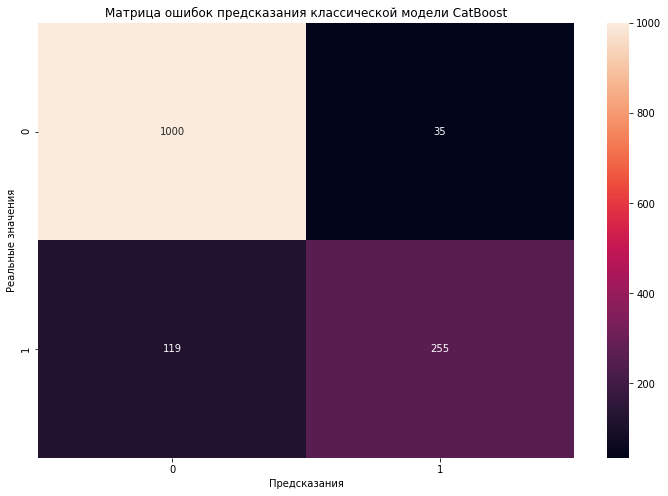

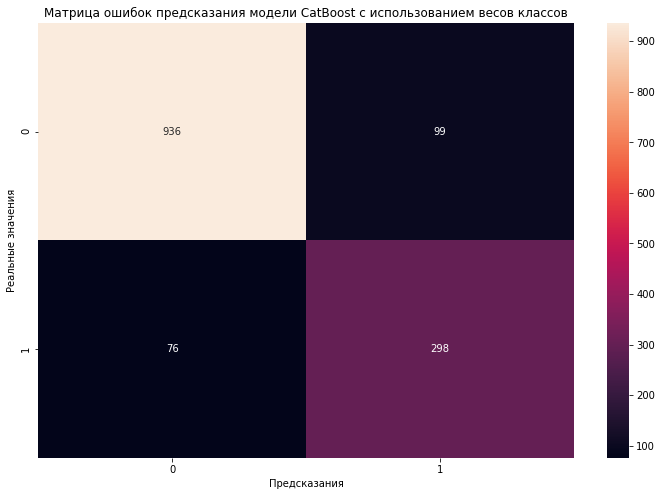

In [79]:
plt.figure(0, figsize=(12,8))
sns.heatmap(confusion_matrix(target_test, cat_predict), annot=True, fmt='g')
plt.title('Матрица ошибок предсказания классической модели CatBoost')
plt.xlabel("Предсказания")
plt.ylabel("Реальные значения")
plt.figure(1, figsize=(12,8))
sns.heatmap(confusion_matrix(target_test, cat_predict_proba), annot=True, fmt='g')
plt.title('Матрица ошибок предсказания модели CatBoost с использованием весов классов')
plt.xlabel("Предсказания")
plt.ylabel("Реальные значения")
plt.show()

## <a id="6"> 6. Чек-лист

1. [x] Загрузка и изучение данных: 
    - [x] создать датафреймы для каждого имеющегося csv-файла;
    - [x] проверить датасеты на соответствие типов признаков значениям, в них представленным;
    - [x] проверить таблицы на наличие дубликатов в записях и пропусков в данных
    - [x] изучить масштаб таблиц (количество признаков и объектов в каждой);
    - [x] определить, какая именно информация хранится в столбцах (что показывают признаки в датафреймах);
    - [x] выделить признаки, существенные для решения поставленной задачи, избавиться от несущественных (при их наличии)


2. [x] Выполнить предобработку данных:
    - [x] избавиться от пропусков, дубликатов, привести данные к соответствию типов;
    - [x] объединить датафреймы в результирующую таблицу


3. [x] Обучение модели
    -  [x] Разделить датасет на обучающую и тестовую выборки, выделить обучающие и целевой признаки;
    -  [x] Определить целевую метрику и ее пороговое значение: **ROC-AUC > 0.75**;
    -  [x] Выполнить подбор гиперпараметров для нескольких моделей, обучить модели;
    -  [x] Выбрать оптимальную для решения поставленной задачи модель.

## <a id="7"> 7. Отчет

1. Все пункты плана были выполнены: мы загрузили и изучили данные, аргументированно обработали пропуски, подготовили датасет для обучения модели. Была проведена работа по обучению нескольких моделей и выбрана модель, показавшая наилучший результат по предсказаниям.


2. В процессе работы возник ряд трудностей: 
    - 2.1. Было непонятно, какие конкретно признаки значимы при предсказании целевого признака. Для оценки влияния бинарных признаков был использован метод **хи-квадрат**, для количественных признаков мы построили диаграммы размаха. Также модель была скорректирована по показателям таблицы **feature_importances_** для обученной модели. Было принято решение отказаться от признаков из общего набора, влияние которых на результат составляло менее 2%.
    - 2.2. Необходимо было принять аргументированное решение по заполнению пропусков: большое количество пропусков образовалось после объединения таблиц. Нами было установлено, что пропуски соответсвуют признакам таблиц `internet` и `phone`, соответсвенно пропуски образовались в строках клиентов, которые не пользуются соответственно услугами интернет или телефонии, предоставляемыми оператором. Было принято решение заполнить пропуски значениями **'No'** для бинарных признаков и **'unknown'** для категориального признака `'internet_service'`.
    - 2.3. Имелась вероятность утечки целевого признака, было принято решение добавить производный признак срока пользования клиента услугами оператора `'lifetime'` и удалить признаки, содержащие даты.
    
    
3. Ключевые шаги при решении поставленной задачи:
    - 3.1. Загрузка и изучение данных: определение размеров исходных таблиц, проблем с типами данных признаков, определение признака, объединяющего таблицы.
    - 3.2. Объединение таблиц в одну, обработка пропусков, более детальное изучение взаимосвязей данных. Определение и добавление в таблицу целевого признака. Построение гистограмм распределения величины платежа клиентов для обоих классов целевого признака.
    - 3.3. Изучение степени влияния обучающих признаков на целевой признак.
    - 3.4. Разделение датасета на **features** и **target**, а также на обучающую и тестовую выборки.
    - 3.5. Обучение нескольких моделей с использованием кросс-валидации, выбор модели с лучшими показателями метрик **ROC-AUC** и **Accuracy**.
    - 3.6. Вывод по проделанной работе и аргументация выбора конкретной модели.
    
    
4. В качестве итоговой модели выбрана модель **CatBoostClassifier** c показателем метрики **ROC-AUC = 0.824**.
        (В качестве альтернативного использования той же модели CatBoostClassifier (обученной на тех же данных и при тех же параметрах) возможно применение классов весов к предсказаниям модели, в таком случае показатель ROC-AUC достигает значения 0.851. Более подробная информация в разделе 5: "Итог. Вывод по работе".